In [ ]:
!pip install tensorflow opencv-python matplotlib keras

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2
import os
import random
import pickle
from google.colab import files
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
TARGETS = [ "non_drones", "drones"]
TRAIN_DATA_PATH = "/content/train_images"
VAL_DATA_PATH = "/content/val_images"
TEST_DATA_PATH = "/content/test_images"

# 1. Load & process data


The load_data function go throguh a current folder path using os libary and create 2D list that contains: (image, label) pairs where the label indicates if the image is a drone(1) or not(0).



In [ ]:
def load_data(data_path):
    data = []
    for target in TARGETS:
        path = os.path.join(data_path, target)
        label = TARGETS.index(target)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            data.append([img_arr, label])
    return data

The prepare_data function go throguh each image-label pair and extract the features(image array) and the matching label. After iterating through all pairs, it converts the lists of features (X) and labels (Y) into numpy arrays. In addition, reshapes the X array to 4D as expectd in the model later.

In [ ]:
def prepare_data (data):
    X = []
    Y = []
    for features, label in data:
        X.append(features)
        Y.append(label)
    X = np.array(X).reshape(-1, 50, 50, 1)
    Y = np.array(Y)
    return X, Y

Load and save the data

In [ ]:
train_data = load_data(TRAIN_DATA_PATH)
val_data = load_data(VAL_DATA_PATH)
test_data = load_data(TEST_DATA_PATH)

In [ ]:
with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)

with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [ ]:
files.download('train_data.pkl')
files.download('val_data.pkl')
files.download('test_data.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

In [ ]:
x_train, y_train = prepare_data(train_data)
x_val, y_val = prepare_data(val_data)
x_test, y_test = prepare_data(test_data)

Scaling the values of the input features(pixel values of an image) to a range between 0 and 1

In [ ]:
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

# 2. Convolutional neural network (CNN) model



The model is sequential-  build layer by layer. Here there are 3 convolutional and pooling layers to extract features from the data with ReLu activation function that introduces non-linearity to the model.

In [ ]:
model = Sequential()
model.add(Conv2D(128, (5,5), input_shape = (50,50,1)))
model.add(Activation("relu"))
model.add(MaxPooling2D (pool_size = (3,3)))

model.add(Conv2D(128, (5,5)))
model.add(Activation("relu"))
model.add(MaxPooling2D (pool_size = (3,3)))

The final layers of the model are flattening the feature maps extracted by the convolutional layers and passing them through dense layers for binary classification using the sigmoid probability function

In [ ]:
model.add(Flatten())
model.add(Dense(128))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.compile(loss = "binary_crossentropy",optimizer = "adam", metrics = ["accuracy"])

model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs = 10)

Epoch 1/10
30/30 [==============================] - 18s 573ms/step - loss: 0.6613 - accuracy: 0.5929 - val_loss: 0.6115 - val_accuracy: 0.6075
Epoch 2/10
30/30 [==============================] - 20s 665ms/step - loss: 0.4772 - accuracy: 0.7830 - val_loss: 0.5500 - val_accuracy: 0.7700
Epoch 3/10
30/30 [==============================] - 18s 575ms/step - loss: 0.3960 - accuracy: 0.8303 - val_loss: 0.5675 - val_accuracy: 0.7625
Epoch 4/10
30/30 [==============================] - 11s 366ms/step - loss: 0.3491 - accuracy: 0.8475 - val_loss: 0.5386 - val_accuracy: 0.7550
Epoch 5/10
30/30 [==============================] - 11s 366ms/step - loss: 0.3208 - accuracy: 0.8743 - val_loss: 0.5077 - val_accuracy: 0.7775
Epoch 6/10
30/30 [==============================] - 11s 356ms/step - loss: 0.2640 - accuracy: 0.9001 - val_loss: 0.5395 - val_accuracy: 0.7725
Epoch 7/10
30/30 [==============================] - 11s 362ms/step - loss: 0.2271 - accuracy: 0.9098 - val_loss: 0.4950 - val_accuracy: 0.7825

# 3. Model results

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 2s 153ms/step - loss: 0.5785 - accuracy: 0.8225
Test Loss: 0.5784544944763184
Test Accuracy: 0.8224999904632568


In [ ]:
probabilities = model.predict(x_test)
binary_labels = (probabilities > 0.5).astype(int)

13/13 [==============================] - 2s 166ms/step


Show 4 random images from the test data with their true and predicted labels

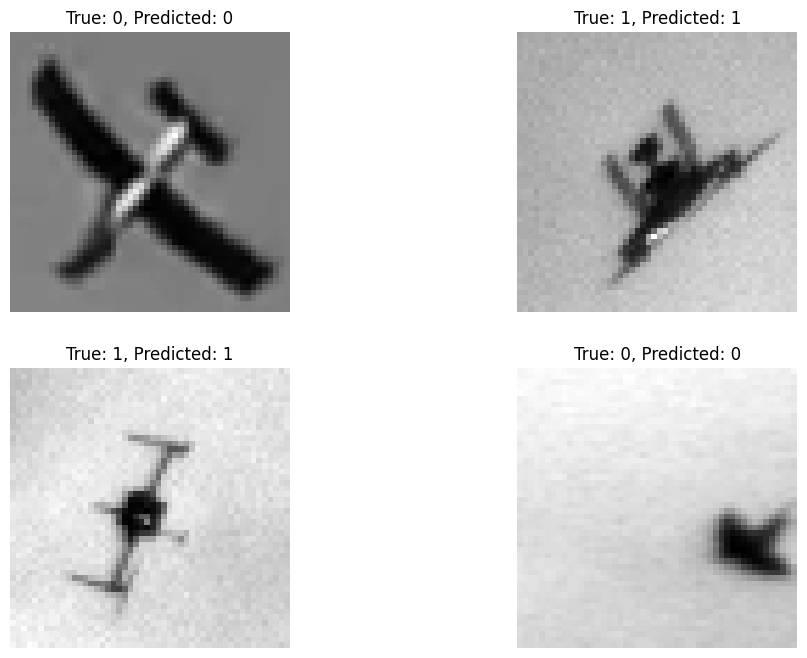

In [ ]:
random_indices = random.sample(range(len(x_test)), 4)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 2, i+1)
    plt.imshow(x_test[idx].reshape(50, 50), cmap='gray', interpolation='nearest')
    true_label = y_test[idx]
    predicted_label = binary_labels[idx][0]
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')
plt.show()

Confusion matrix

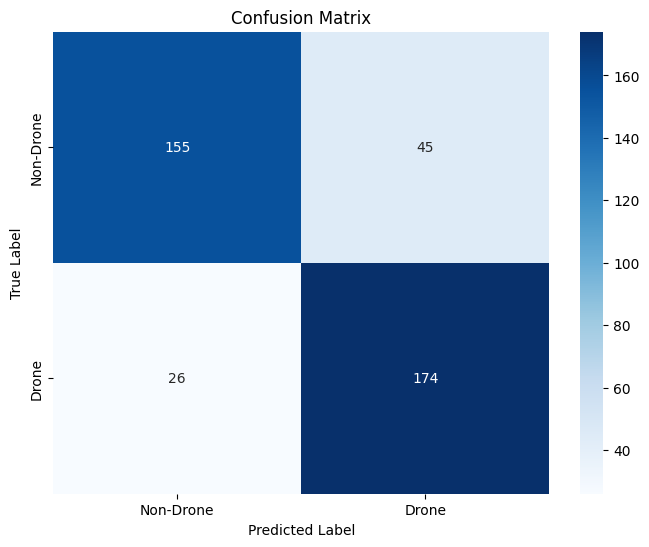

In [ ]:
cm = confusion_matrix(y_test, binary_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Drone', 'Drone'], yticklabels=['Non-Drone', 'Drone'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Save as TFLite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('image_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)

# 4.  load the model and perform on input images

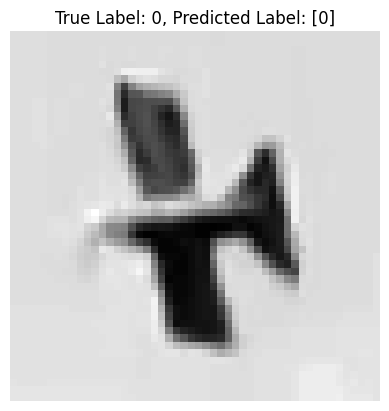

In [ ]:
interpreter = tf.lite.Interpreter(model_path='image_classification_model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

random_index = random.randint(0, len(x_test) - 1)
random_image = x_test[random_index]
random_image = random_image.astype(np.float32)
random_label = y_test[random_index]

interpreter.set_tensor(input_details[0]['index'], np.expand_dims(random_image, axis=0))
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
binary_prediction = (output > 0.5).astype(int)

plt.imshow(random_image.reshape(50, 50), cmap='gray')
plt.title(f'True Label: {random_label}, Predicted Label: {binary_prediction[0]}')
plt.axis('off')
plt.show()

